In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer


In [2]:
# Load UNSW-NB15 dataset (using nids-datasets package)
data = pd.read_csv('/content/drive/MyDrive/NIDS/UNSW_NB15_training-set.csv')


In [3]:
data.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [4]:
# Separate features and target
X_train = data.drop('label', axis=1)
y_train = data['label']

# Preprocess data
 # Handle categorical features
X_train = pd.get_dummies(X_train)

# #fill missing data
# imputer = SimpleImputer(strategy='mean')  # we can choose other strategies like 'median'as well.
# X_train = imputer.fit_transform(X_train)


# Split data
test=pd.read_csv('/content/drive/MyDrive/NIDS/UNSW_NB15_testing-set.csv')
X_test = test.drop('label', axis=1)
y_test = test['label']

X_test = pd.get_dummies(X_test)

In [5]:
# Handle categorical features and ensure consistent columns between train and test
# Get combined set of all features
all_features = pd.concat([X_train, X_test], ignore_index=True)
all_features = pd.get_dummies(all_features)

# Split back into train and test sets
X_train = all_features.iloc[:X_train.shape[0], :]
X_test = all_features.iloc[X_train.shape[0]:, :]

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
X_train

array([[-1.73202977, -0.21372745, -0.1244551 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.7319877 , -0.21372808, -0.1244551 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.73194562, -0.21372872, -0.1244551 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.73194562, -0.21372978, -0.1319225 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.7319877 , -0.21372978, -0.1319225 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.73202977, -0.21372787, -0.1244551 , ...,  0.        ,
         0.        ,  0.        ]])

In [8]:

# Define base models
base_models = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('knn', KNeighborsClassifier()),
    ('svm', SVC(probability=True, random_state=42))
]

# Define meta-model
meta_model = LogisticRegression(random_state=42)

# Create stacking ensemble
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    stack_method='predict_proba'
)



In [9]:
# Train the stacking ensemble
stacking_model.fit(X_train, y_train)





StackingClassifier(cv=5,
                   estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('knn', KNeighborsClassifier()),
                               ('svm', SVC(probability=True, random_state=42))],
                   final_estimator=LogisticRegression(random_state=42),
                   stack_method='predict_proba')

In [10]:
# Make predictions
y_pred = stacking_model.predict(X_test)



Stacking Ensemble Performance:
Accuracy: 0.9984
Precision: 0.9984
Recall: 0.9984
F1 Score: 0.9984

Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56000
           1       1.00      1.00      1.00    119341

    accuracy                           1.00    175341
   macro avg       1.00      1.00      1.00    175341
weighted avg       1.00      1.00      1.00    175341



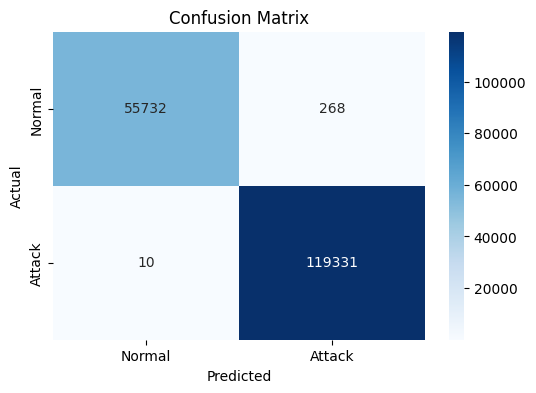

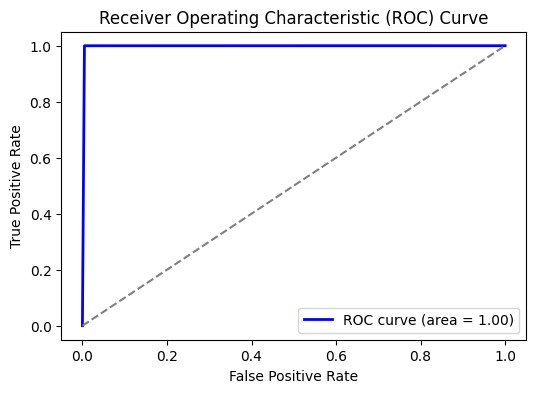

In [11]:
# Evaluate performance
print("Stacking Ensemble Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted'):.4f}")
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
